# Stock Prices

_In physics it takes three laws to explain 99% of the data; in finance it takes more than 99 laws to explain about 3%_ - Andrew Lo 

Concepts:
- Stock splits, dividends and delistings
- Properties of stock returns

__References:__

- Fama, Eugene F., and Kenneth R. French. 1992. “The cross-section of expected stock returns.” The Journal of Finance 47 (2): 427–65.

- Shumway, Tyler. 1997. The Delisting Bias in CRSP Data. The Journal of Finance, 52, 327-340. 

- Bali, Turan G, Robert F Engle, and Scott Murray. 2016. Empirical asset pricing: The cross section of stock returns. John Wiley & Sons.

- Stulz, René M., 2018, "The Shrinking Universe of Public Firms: Facts, Causes, and Consequences", National Bureau of Economics, 2 (June 2018)

- FRM Exam Book Part I Quantative Analysis Chapter 12



In [2]:
import numpy as np
import scipy
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from tqdm import tqdm
from finds.database import SQL, RedisDB
from finds.structured import BusDay, CRSP, CRSPBuffer, Benchmarks
from finds.utils import Finder, plot_date
from secret import credentials, CRSP_DATE, paths
VERBOSE = 0

# %matplotlib qt

In [3]:
# open database connections
sql = SQL(**credentials['sql'], verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
bd = BusDay(sql, endweek=3, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb=rdb, verbose=VERBOSE)
bench = Benchmarks(sql, bd, verbose=VERBOSE)
find = Finder(sql)
outdir = paths['scratch']

## Measuring stock returns

Long time-series and broad cross-sections of US stock price data are best managed in a structured database. This facilitates linking across data sources, where data vendors or financial organizations may use different identifiers, and the tracking of identifier changes and corporate actions (e.g. splits, dividends, delistings and mergers) over time.

### SQL 

Structured query language (SQL) is a standard language for database creation and manipulation. 
MySQL is a popular open-source package that uses structured query language (SQL) for data management. Python toolkits such as SQLAlchemy provide an interface for using an SQL database.
The Python Pandas library also provides methods such as `pandas.read_sql` to query a database table and return in a DataFrame.

SQL Cheatsheet:

__Manage tables__

CREATE DATABASE -- Creates a new database.

CREATE TABLE -- Creates a new table. 

DELETE -- Delete data from a table.

DROP COLUMN -- Deletes a column from a table.

DROP DATABASE -- Deletes the entire database.

DROP TABLE -- Deletes a table from a database.

TRUNCATE TABLE -- Deletes the data but does not delete the table.



__Querying a table__

SELECT -- Used to select data from a database, which is then returned in a results set.

SELECT DISTINCT -- Sames as SELECT, except duplicate values are excluded.

SELECT INTO -- Copies data from one table and inserts it into another.

UNIQUE -- This constraint ensures all values in a column are unique.

FROM -- Specifies which table to select or delete data from.

AS -- Renames a table or column with an alias value which only exists for the duration of the query.

__Query conditions__

WHERE -- Filters results to only include data which meets the given condition.

AND -- Used to join separate conditions within a WHERE clause.

BETWEEN -- Selects values within the given range.

IS NULL -- Tests for empty (NULL) values.

IS NOT NULL -- The reverse of NULL. Tests for values that aren’t empty / NULL.

LIKE -- Returns true if the operand value matches a pattern.

NOT -- Returns true if a record DOESN’T meet the condition.
 
OR -- Used alongside WHERE to include data when either condition is true.

__Organize results__

ORDER BY -- Used to sort the result data in ascending (default) or descending order through the use of ASC or DESC keywords.

GROUP BY -- Used alongside aggregate functions (COUNT, MAX, MIN, SUM, AVG) to group the results.

__Join tables__

INNER JOIN returns rows that have matching values in both tables.

LEFT JOIN returns all rows from the left table, and the matching rows from the right table.- 

RIGHT JOIN returns all rows from the right table, and the matching records from the left table

FULL OUTER JOIN returns all rows when there is a match in either left table or right table.

### Redis

Redis is an open-source, in-memory data structure store that can be used as a caching layer to store frequently accessed data and reduce the load on primary databases.


In [4]:
# inner join of identifier tables

# double up the % in a pandas string
pd.read_sql("select * from benchident where name like '%%momentum%%'", con=sql.engine)

cmd = """
select * from benchident inner join benchmarks
on benchident.permno = benchmarks.permno
where benchident.name like '%%momentum%%'
  and benchident.permno like '%%(mo)%%'
limit 5
"""
pd.read_sql(cmd, con=sql.engine)

,permno,name,item,permno,date,ret
0,Mom(mo),F-F_Momentum_Factor,0,Mom(mo),19270131,0.0036
1,Mom(mo),F-F_Momentum_Factor,0,Mom(mo),19270228,-0.0214
2,Mom(mo),F-F_Momentum_Factor,0,Mom(mo),19270331,0.0361
3,Mom(mo),F-F_Momentum_Factor,0,Mom(mo),19270430,0.0430
4,Mom(mo),F-F_Momentum_Factor,0,Mom(mo),19270531,0.0300


### CRSP stocks data

The Center for Research in Security Prices (CRSP) provides the most widely used data for academic research into US stocks. It includes both successful and unsuccessful entities, rather than just those that have "survived" over time. This helps avoid the pitfalls of focusing only on surviving entities which can lead to an overestimation of average performance and underestimation of risk.

Following Fama and French (1992), only US-domiciled (`shrcd` in [10, 11]), exchange-listed (`exchcd` in [1, 2, 3]) stocks are typically considered for equities research. The universe is often divided into 10 market capitalization-based deciles (with the 10th decile comprising the smallest stocks) whose breakpoints are determined only from those
stocks listed on the NYSE.  For a company with multiple classes securities, the combined market value of the company is used for all classes of its securities.  The shrout (shares outstanding) field in CRSP is in units of  thousands of shares. Hence all calculations and derivations (such as market capitalization) need to be multipled by 1000 to get the true value.


Stulz (2018) and others hvae noted the shrinking universe of public US firms and increased concentration of mega-cap stocks in recent years. These observations are consistent with plots  of the market cap breakpoints of and the number of stocks in each decile by year. 




In [5]:
# retrieve universe of stocks annually from 1981
start = bd.endyr(19731231)
rebals = bd.date_range(start, CRSP_DATE, freq=12)
univs = {rebal: crsp.get_universe(date=rebal) for rebal in rebals}
num = dict()
for date, univ in univs.items():
    num[str(date//10000)] = {decile: sum(univ['decile']==decile)
                             for decile in range(10, 0, -1)}
num = DataFrame.from_dict(num, orient='index')

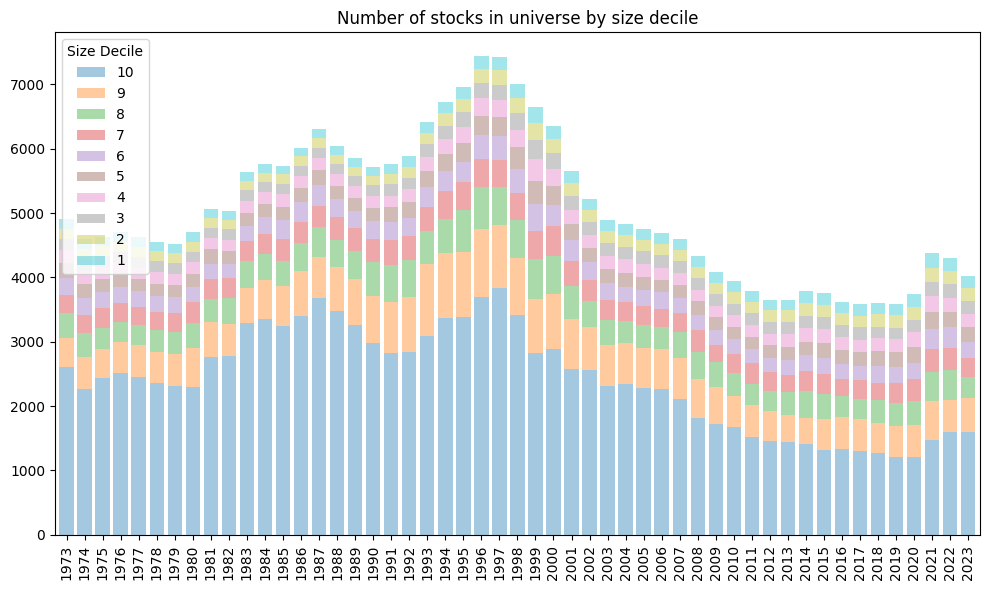

In [6]:
# plot number of stocks in each size decile
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Number of stocks in universe by size decile')
num.plot.bar(stacked=True, ax=ax, width=.8, alpha=0.4)
#set_xtickbins(ax=ax, nbins=len(cap)//10)
plt.legend(title='Size Decile', loc='upper left')
plt.tight_layout()

In [7]:
# For assigning into size deciles, sum up the company's total market
# capitalization instead of separate capital values each security if multiple classes
names = find('ALPHABET', 'comnam').groupby('permno').tail(1).set_index('permno')
find(names['permco'].iloc[0], identifier='permco')

,date,comnam,ncusip,shrcls,ticker,permno,nameendt,shrcd,exchcd,siccd,tsymbol,naics,primexch,trdstat,secstat,permco
0,20040819,GOOGLE INC,38259P50,A,GOOG,90319,20050818,11,3,7375,GOOG,514191,Q,A,R,45483
1,20050819,GOOGLE INC,38259P50,A,GOOG,90319,20060720,11,3,7375,GOOG,518111,Q,A,R,45483
2,20060721,GOOGLE INC,38259P50,A,GOOG,90319,20080131,11,3,7375,GOOG,518112,Q,A,R,45483
3,20080201,GOOGLE INC,38259P50,A,GOOG,90319,20140402,11,3,7375,GOOG,519130,Q,A,R,45483
4,20140403,GOOGLE INC,38259P70,C,GOOG,14542,20150423,11,3,7375,GOOG,519130,Q,A,R,45483
5,20140403,GOOGLE INC,38259P50,A,GOOGL,90319,20150423,11,3,7375,GOOGL,519130,Q,A,R,45483
6,20150424,GOOGLE INC,38259P70,C,GOOG,14542,20151004,11,3,7375,GOOG,519190,Q,A,R,45483
7,20150424,GOOGLE INC,38259P50,A,GOOGL,90319,20151004,11,3,7375,GOOGL,519190,Q,A,R,45483
8,20151005,ALPHABET INC,02079K10,C,GOOG,14542,20180201,11,3,7375,GOOG,519190,Q,A,R,45483
9,20151005,ALPHABET INC,02079K30,A,GOOGL,90319,20180201,11,3,7375,GOOGL,519190,Q,A,R,45483


In [8]:
univ.loc[names.index]  # market caps of share class and total company

,cap,capco,decile,nyse,siccd,prc,naics
permno,,,,,,,
14542,806824250.0,1.633510e+09,1,False,7375,140.93,541511
90319,826685420.0,1.633510e+09,1,False,7375,139.69,541511


### Stock distributions

In addition to gains from appreciated stock prices, adjusted for stock splits (`facpr` in CRSP), investors' total holding returns also include ordinary cash dividends (`divamt` in CRSP).

The total holding return on an asset from $t-1$ to $t$ includes both price appreciation and any dividends paid on record date $t$: $R_t = \dfrac{P_t + D_t - P_{t-1}}{P_{t-1}}$. Ex-dividend means a company's dividend allocations have been specified. The ex-dividend date or "ex-date" is usually one business day before the record date.

The return of an asset over multiple periods is calculated using the product of the simple returns in each period: $1 + R_T = \Pi_{t=1}^{T} (1 + R_t)$.  This implicitly assumes that dividends have been reinvested in the same asset.

There are also continuously compounded returns, or log returns. These are computed as the difference of the natural logarithm of the price: $r_t = ln Pt - ln Pt - 1 


### Yahoo Finance data

- The historical "close" from Yahoo Finance is the split-adjusted price
- The historical "adjclose" from Yahoo Finance is equal to the dividend- and split-adjusted price:
  Daily changes of "adjclose" reflects the total holdings returns which includes the effect of both stock splits and cash dividends received.



In [9]:
# Prices from Yahoo Finance
from yahoo import get_price
ticker = 'AAPL'
date = 20200101
df = get_price(ticker, start_date=date, verbose=VERBOSE)
df.rename_axis(ticker)
prices_columns = df.columns
df.round(2)

,open,high,low,close,adjClose,volume
20200103,74.29,75.14,74.12,74.36,72.25,146322800.0
20200106,73.45,74.99,73.19,74.95,72.83,118387200.0
20200107,74.96,75.22,74.37,74.60,72.48,108872000.0
20200108,74.29,76.11,74.29,75.80,73.65,132079200.0
20200109,76.81,77.61,76.55,77.41,75.21,170108400.0
...,...,...,...,...,...,...
20240624,207.72,212.70,206.59,208.14,208.14,80727000.0
20240625,209.15,211.38,208.61,209.07,209.07,56713900.0
20240626,211.50,214.86,210.64,213.25,213.25,66213200.0
20240627,214.69,215.74,212.35,214.10,214.10,49772700.0


In [10]:
df = get_price(ticker, start_date=date, verbose=VERBOSE)

<Axes: title={'center': 'AAPL prices from Yahoo Finance'}>

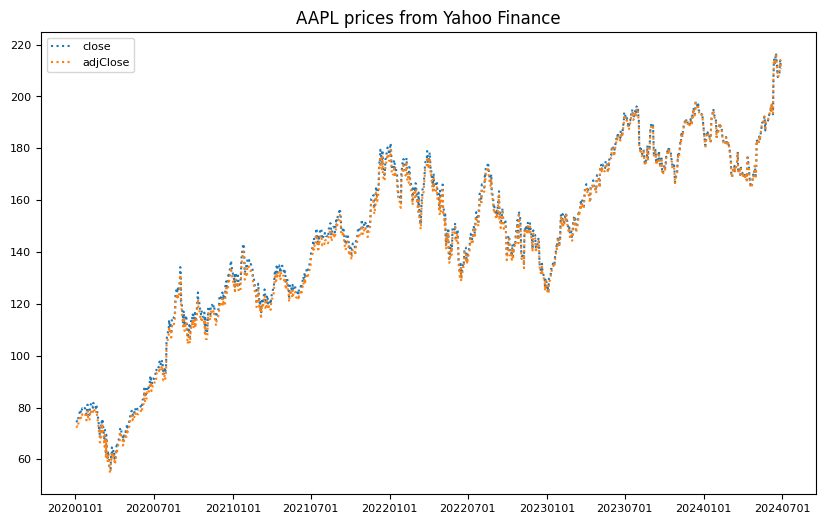

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_date(df[['close', 'adjClose']], legend1=['close', 'adjClose'],
          title=f"{ticker} prices from Yahoo Finance",
          ls=':', fontsize=8, rotation=0, cn=0, ax=ax)

__Dividends__

Differences between daily changes in adjClose and close on ex-dates are estimates of dividend amounts (scaled by prior adjClose).


In [12]:
# Lookup AAPL's permno identifier
find = Finder(sql)
permno = find('AAPL').tail(1)['permno'].iloc[0]

In [13]:
# dividend yield is excess of change in adjClose over chance in close
df['divyld'] = ((df['adjClose'] / df['adjClose'].shift())
                / (df['close'] / df['close'].shift())) - 1
# ex-dates inferred to be when amount is larger than rounding error
exdt = df.index[abs(df['divyld']) > .0001]
yahoo_div = df.loc[exdt, 'divyld']

__Dividend amount per share__ from CRSP distributions


In [14]:
crsp_div = DataFrame(**sql.run(f"""
SELECT divamt, exdt, retx, prc FROM dist INNER JOIN daily
ON dist.permno = daily.permno AND dist.exdt = daily.date AND dist.exdt <= {CRSP_DATE}
WHERE dist.permno={permno} AND dist.exdt>{date} AND dist.divamt > 0
""".strip()))
crsp_div = crsp_div.set_index('exdt').sort_index()
crsp_div

,divamt,retx,prc
exdt,,,
20200207,0.770,-0.015928,320.03
20200508,0.820,0.021038,310.13
20200807,0.820,-0.024495,444.45
20201106,0.205,-0.002856,118.69
20210205,0.205,-0.004586,136.76
20210507,0.220,0.003623,130.21
20210806,0.220,-0.006256,146.14
20211105,0.220,0.002120,151.28
20220204,0.220,-0.002950,172.39


In [15]:
# Compare CRSP actual and Yahoo Finance estimated dividend amounts
div = crsp_div.join(yahoo_div)
div['yahoo_div'] = div['divyld'] * (div['prc'] / (1 + div['retx']))
div[['divamt', 'yahoo_div', 'prc']].round(3)

,divamt,yahoo_div,prc
exdt,,,
20200207,0.770,0.772,320.03
20200508,0.820,0.822,310.13
20200807,0.820,0.822,444.45
20201106,0.205,0.205,118.69
20210205,0.205,0.205,136.76
20210507,0.220,0.220,130.21
20210806,0.220,0.220,146.14
20211105,0.220,0.220,151.28
20220204,0.220,0.220,172.39


__Split adjustment factors__ from CRSP




In [16]:
crsp_fac = DataFrame(**sql.run(f"""
SELECT 1 + facpr as facpr, exdt FROM dist 
WHERE permno={permno} AND exdt>{date} AND facpr > 0.0
""".strip())).set_index('exdt').sort_index(ascending=False).cumprod()

In [17]:
# Retrieve CRSP raw prices around ex-dates
crsp_prc = DataFrame(**sql.run(f"""
SELECT date, prc from daily
WHERE permno={permno} AND date>{bd.offset(crsp_fac.index[0],-5)}
  AND date<{bd.offset(crsp_fac.index[-1],5)}
""".strip())).set_index('date')

The Factor to Adjust Price, `facpr`, can be used to adjust prices for
distributions (usually stock dividends and splits) so that stock prices
before and after the distribution are comparable.  

The historical cumulative adjust factors are computed by additing 1 to and then taking cumulative product from current to earlier time periods. This cumulative factor between two dates is divided into the earlier raw stock price to derive comparable split-adjusted prices. Hence to split-adjust CRSP raw prices
- apply cumulative factor to raw prices before corresponding ex-date
- back-fill to dates prior to ex-date
- default factor after latest ex-date is 1


In [18]:
# Compare split-adjusted CRSP price to Yahoo Finance close price
crsp_fac = crsp_fac.reindex(crsp_prc.index)\
                   .shift(-1)\
                   .bfill()\
                   .fillna(1)\
                   .join(crsp_prc)
crsp_fac['prc_adjusted'] = crsp_fac['prc'] / crsp_fac['facpr']
crsp_fac[['prc', 'prc_adjusted']].join(df['close'], how='left').round(3)

,prc,prc_adjusted,close
date,,,
20200825,499.30,124.825,124.825
20200826,506.09,126.522,126.522
20200827,500.04,125.010,125.010
20200828,499.23,124.808,124.808
20200831,129.04,129.040,129.040
20200901,134.18,134.180,134.180
20200902,131.40,131.400,131.400
20200903,120.88,120.880,120.880
20200904,120.96,120.960,120.960


### Stock delistings

An important feature of the CRSP database is that it is free of survivorship-bias.  It includes the historical records of stocks that have delisted from trading on the exchanges.

In CRSP Monthly, the Delisting Return is calculated from the last
month ending price to the last daily trading price if no other
delisting information is available. In this case the delisting
payment date is the same as the delisting date.  If the return is
calculated from a daily price, it is a partial-month return. The
partial-month returns are not truly Delisting Returns since they do
not represent values after delisting, but allow the researcher to
make a more accurate estimate of the Delisting Returns.

Following Bali, Engle, and Murray (2016) and Shumway (1997): we can
construct returns adjusted for delistings, which result when a
company is acquired, ceases operations, or fails to meet exchange
listing requirements. The adjustment reflects the partial month of
returns to investors who bought the stock in the month before the
delisting. For certain delisting codes ([500, 520, 551..574, 580,
584]) where the delisting return is missing, a delisting return of -30%
is assumed which reflects the average recovery amount after delisting.

In [19]:
# Show sample of original CRSP Monthly ret and dlret, and after adjustment            
pd.read_sql('select * from monthly where dlstcd>100 and date=20041130', sql.engine)\
  .set_index('permno')\
  .rename(columns={'ret': 'original_ret'})\
  .join(crsp.get_ret(beg=20041101, end=20041130), how='left')\
  .round(4)

,date,prc,original_ret,retx,dlstcd,dlret,ret
permno,,,,,,,
10275,20041130,NaN,NaN,NaN,584,-0.2703,-0.2703
10418,20041130,NaN,NaN,NaN,520,0.0509,0.0509
11194,20041130,NaN,NaN,NaN,233,0.0066,0.0066
12010,20041130,NaN,NaN,NaN,587,0.0490,0.0490
20459,20041130,NaN,NaN,NaN,231,0.0724,0.0724
32897,20041130,NaN,NaN,NaN,584,-0.2357,-0.2357
55589,20041130,NaN,NaN,NaN,233,-0.0114,-0.0114
64290,20041130,13.70,0.0178,0.0178,233,0.0000,0.0178
67708,20041130,NaN,NaN,NaN,233,0.0164,0.0164


## Properties of stock returns

### Long-run market averages

- total stock returns
- dividend yield
- shares trading turnover

Equal-weighted time-series means of
annual cap-weighted cross-sectional averages of universe stocks 


In [20]:
# Loop over the 20-year eras, and compute means of annual cap-weighted averages
years = [2005, 1985, 1965, 1945, 1925]
results = DataFrame(columns=['divyld', 'turnover', 'means'])
for era in tqdm(years):
    label = f"{era+1}-{min(era+20, CRSP_DATE // 10000)}"
    divyld = {}
    means = {}
    turnover = {}
    for year in bd.date_range(era, min(CRSP_DATE // 10000, era+20), freq=12):
        univ = crsp.get_universe(bd.endyr(year))  # screen for universe stocks

        # Retrieve and compute cap-weighted average of annual returns
        cmd = f"""
select permno, SUM(LOG(1+ret)) AS ret FROM daily
WHERE date > {bd.endyr(year)} AND date <= {bd.endyr(year, 1)}
GROUP BY permno
""".strip()
        data = pd.read_sql(cmd, sql.engine)
        df = data.set_index('permno').join(univ['cap'], how='right').dropna()
        means[year] = (np.exp(df['ret'])-1).dot(df['cap']) / df['cap'].sum()

        # Retrieve and compute cap-weighted average of annualized turnover
        cmd = f"""
select permno, 252*AVG(vol/(shrout*1000)) AS turnover FROM daily
WHERE date > {bd.endyr(year)} AND date <= {bd.endyr(year, 1)}
GROUP BY permno
""".strip()
        data = pd.read_sql(cmd, sql.engine)
        df = data.set_index('permno').join(univ['cap'], how='right').dropna()
        turnover[year] = df['turnover'].dot(df['cap']) / df['cap'].sum()

        # Retrieve and compute cap-weighted average of annual dividend amounts
        cmd = f"""
SELECT dist.permno as permno, SUM(daily.shrout * dist.divamt) AS divamt
FROM dist INNER JOIN daily
ON daily.permno = dist.permno AND daily.date = dist.exdt
WHERE dist.divamt > 0 AND dist.exdt > {bd.endyr(year)} 
  AND dist.exdt <= {bd.endyr(year, 1)}
GROUP BY permno
""".strip()
        data = pd.read_sql(cmd, sql.engine)
        df = data.set_index('permno').join(univ['cap'], how='right').dropna()
        divyld[year] = df['divamt'].sum() / df['cap'].sum()

    results.loc[label, 'turnover'] = np.mean(list(turnover.values()))
    results.loc[label, 'divyld'] = np.mean(list(divyld.values()))
    results.loc[label, 'means'] = np.mean(list(means.values()))

100%|██████████| 5/5 [1:10:45<00:00, 849.19s/it]


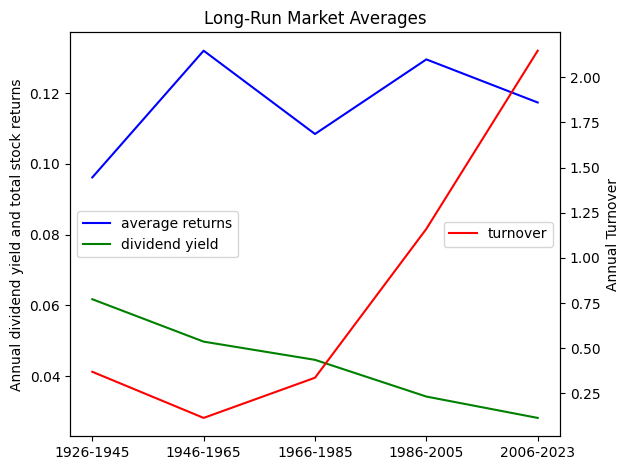

In [21]:
# Plot mean returns, dividend yield and turnover using both y-axes
results = results.iloc[::-1]
fig, ax = plt.subplots()
ax.plot(results['means'], color="blue")
ax.plot(results['divyld'], color="green")
ax.legend(['average returns', 'dividend yield'], loc="center left")
ax.set_ylabel("Annual dividend yield and total stock returns")
bx = ax.twinx()
bx.plot(results['turnover'], color="red")
bx.set_ylabel("Annual Turnover")
bx.legend(['turnover'], loc="center right")
plt.title("Long-Run Market Averages")
plt.tight_layout()



### Moments pf individual stock returns


- The volatility of an asset is usually measured using the standard deviation of the returns. The common practice is to report the annualized volatility using the square-root rule which assumes that variance scales linearly with time: e.g.
daily by $\sqrt{252}$, weekly by $\sqrt{52}$, monthly by $\sqrt{12}$

- Means are computed from log returns, and annualized by multiplying by the respective number of periods in a year.  We use log returns $\log{1+R_t}$ instead of simple returns $R_t$ to skirt around some of the issues related to translating between arithmetic and geometric averages. It has been shown that:
  - By Jensen's inequality, the arithmetic mean is greater than the geometric mean
  - Under the assumption of log-normality, the arithmetic mean exceeds the geometric means of returns by half the volatility.

- A normal distribution is symmetric and thin-tailed, and so has no skewness or excess kurtosis. However, many return series are both skewed and fat-tailed (kurtosis in excess of 3). 
  - A left-skewed distribution is longer on the left side of its peak than on its right. In other words, a left-skewed distribution has a long tail on its left side, where the mean typically lies to the left of its median. Left skew is also referred to as negative skew.
  - Right or positive skew has the opposite properties.


The Jarque-Bera test statistic can be used to test whether the sample skewness and kurtosis are compatible with an assumption that the returns are normally distributed. When returns are normally distributed, the skewness is asymptotically normally distributed with a variance of 6, so (skewness)$^2/6$ has a $\chi^2_1$
distribution. Meanwhile, the kurtosis is asymptotically normally distributed with mean 3 and variance of 24, and so (kurtosis - 3)$^2/24$ also has a $\chi^2_1$
distribution. These two statistics are
asymptotically independent (uncorrelated), and so their sum is $~\chi^2_2$


In [22]:
# helper function
def get_moments(freq, annualize, years, stride=20):
    """helper to summarize moments of individual stock returns"""
    out = {}
    years = sorted(years)
    max_era = min(CRSP_DATE, bd.endyr(max(years) + stride)) # end year of last era

    # Use StocksBuffer to cache monthly returns for entire era
    if freq not in ['d', 'w']:
        monthly = CRSPBuffer(stocks=crsp, dataset='monthly', fields=['ret'],
                             beg=bd.endyr(years[0]), end=max_era)
    for era, next_era in zip(years, years[1:] + [max_era]):
        allstocks = DataFrame()
        anystocks = DataFrame()
        univ_year = bd.endyr(era)  # universe as of end of previous calendar year

        # Loop over calendar years in era
        endyrs = bd.date_range(bd.endyr(era), bd.endyr(next_era), freq=freq)
        for beg, end in tqdm(bd.date_tuples(endyrs)):
            
            # Update the investment universe every calendar year
            if bd.endyr(beg) != univ_year:
                univ = crsp.get_universe(univ_year)
                univ_year = bd.endyr(beg)

                # Use StocksBuffer to cache daily returns for the calendar year
                if freq == 'd':
                    daily = CRSPBuffer(stocks=crsp, dataset='daily', fields=['ret'],
                                       beg=bd.offset(beg, -1), end=bd.endyr(end))
                    
            # retrieve returns
            if freq == 'd':
                ret = daily.get_ret(beg=beg, end=end).reindex(univ.index)
            elif freq == 'w':
                ret = crsp.get_ret(beg=beg, end=end).reindex(univ.index)
            else:    # monthly or coarser
                ret = monthly.get_ret(beg=beg, end=end).reindex(univ.index)

            # horizontally stack returns
            if allstocks.empty:
                allstocks = DataFrame(ret.rename(end))
            else:   # every year                 
                allstocks = allstocks.join(ret.rename(end), how='inner')
            anystocks = anystocks.join(ret.rename(end), how='outer')  # any year

        anystocks = anystocks.dropna(axis=0, how='all')        # drop empty rows    
        out[f"{str(era)[:4]}-{int(str(next_era)[:4]) - 1}"] = {
            f"VolAnnualized": np.nanmedian(
                np.nanstd(allstocks, axis=1, ddof=0)) * np.sqrt(annualize),
            f"Skewness": np.nanmedian(
                scipy.stats.skew(allstocks, nan_policy='omit', axis=1)),
            f"ExcessKurtosis": np.nanmedian(
                scipy.stats.kurtosis(allstocks, nan_policy='omit', axis=1)),
            f"Count": len(allstocks),
            f"MeanAnnualized": np.nanmedian(
                np.nanmean(np.log(1 + allstocks), axis=1)) * annualize,
            f"Mean (all stocks)": np.nanmedian(
                np.nanmean(np.log(1 + anystocks), axis=1)) * annualize,
            f"Count (all stocks)": len(anystocks),
        }
    return out

In [23]:
# Collect results for different intervals and eras
intervals = [('d', 'daily', 252), ('w', 'weekly', 52), ('e', 'monthly', 12),
             (12, 'annual', 1)]          # different returns sampling frequencies
years = [2005, 1985, 1965, 1945, 1925]   # 20-year periods
results = DataFrame()
#results = pd.read_json(outdir / 'moments.json')
#results = results.set_index(results.columns[0])
for order, (freq, interval, annualize) in enumerate(intervals):
    df = DataFrame(get_moments(freq, annualize, years, stride=20)).reset_index()
    df['interval'] = interval

    # set index so that rows can be ordered by moment then freq
    df.index = [f"{moment}{order}" for moment in range(len(df))]
    results = pd.concat((results, df))  # accumulate df to results
    results.reset_index().to_json(outdir / 'moments.json')
    

100%|██████████| 240/240 [00:18<00:00, 13.14it/s]
/home/terence/env3.11/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 240/240 [00:25<00:00,  9.28it/s]
/home/terence/env3.11/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 240/240 [00:27<00:00,  8.61it/s]
/home/terence/env3.11/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 240/240 [00:25<00:00,  9.32it/s]
/home/terence/env3.11/lib/python3.11/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 216/216 [00:18<00:00, 11.37it/s]
/home/terence/env3.11/lib/python3.11/site-

In [24]:
out = results.sort_index().rename(columns={'index':'moment'})

In [25]:
# Show medians of the moments of individual stock returns
out[~out['moment'].str.startswith("Count") &
    ~out['moment'].str.startswith("Mean")].set_index(['interval', 'moment']).round(3)

,,1925-1944,1945-1964,1965-1984,1985-2004,2005-2022
interval,moment,,,,,
daily,VolAnnualized,0.543,0.267,0.337,0.392,0.437
weekly,VolAnnualized,0.540,0.254,0.347,0.366,0.407
monthly,VolAnnualized,0.553,0.244,0.340,0.355,0.381
annual,VolAnnualized,0.553,0.296,0.382,0.379,0.360
daily,Skewness,0.909,0.315,0.528,0.339,0.395
weekly,Skewness,0.932,0.528,0.627,0.343,0.281
monthly,Skewness,1.257,0.484,0.597,0.381,0.307
annual,Skewness,0.751,0.582,0.628,0.684,0.423
daily,ExcessKurtosis,14.887,5.446,4.926,8.749,13.268


In [26]:
# Show counts of stocks
out[out['moment'].str.startswith("Count")].set_index(['interval', 'moment']).astype(int)

,,1925-1944,1945-1964,1965-1984,1985-2004,2005-2022
interval,moment,,,,,
daily,Count,305,606,877,1219,1579
weekly,Count,305,606,877,1219,1579
monthly,Count,305,606,877,1219,1579
annual,Count,305,606,877,1219,1579
daily,Count (all stocks),1082,2448,10089,16273,9050
weekly,Count (all stocks),1082,2447,10084,16271,9042
monthly,Count (all stocks),1082,2448,10088,16273,9049
annual,Count (all stocks),1082,2448,10088,16273,9049


In [27]:
# Show medians of mean individual stock returns
out[out['moment'].str.startswith("Mean")].set_index(['interval', 'moment']).round(3)

,,1925-1944,1945-1964,1965-1984,1985-2004,2005-2022
interval,moment,,,,,
daily,MeanAnnualized,0.040,0.104,0.089,0.099,0.059
weekly,MeanAnnualized,0.046,0.109,0.087,0.100,0.057
monthly,MeanAnnualized,0.047,0.108,0.088,0.099,0.059
annual,MeanAnnualized,0.047,0.108,0.088,0.099,0.059
daily,Mean (all stocks),0.052,0.114,0.059,0.009,0.006
weekly,Mean (all stocks),0.061,0.118,0.057,0.010,0.004
monthly,Mean (all stocks),0.063,0.118,0.059,0.009,0.007
annual,Mean (all stocks),0.061,0.116,0.056,0.008,0.006


### Correlations

The linear correlation estimator (also known as Pearson’s correlation) measures the linear relationship between two variables. Alternative measures can help capture nonlinear dependence:
- rank correlation (or Spearman's correlation) is the linear correlation estimator applied to the ranks of the observations. It measures monotoric correlation and is less sensitive to outliers.
- Kendall's $\tau$ measures the relative frequency of concordant and discordant pairs of two random variables X and Y. Concordant pairs agree about the relative position of X and Y, while pairs that disagree about the order are discordant. This statistic is robust to outliers and works well with skewed or non-normally distributed data.
  
Computing these measures between the value-weighted and equal-weighted total daily market returns suggests that the high estimated linear correlation may be sensitive to outliers, compared to estimators that are less.
 

In [28]:
# retrieve CRSP value- and equal-weighted total market returns
retd = bench.get_series(['vwretd', 'ewretd'], field='ret').dropna()
retd


permno,vwretd,ewretd
date,,
19260102,0.004297,0.002941
19260104,-0.001357,0.001036
19260105,-0.004603,-0.005856
19260106,0.000537,0.000888
19260107,0.003907,0.004258
...,...,...
20231222,0.001708,0.003380
20231226,0.004208,0.005969
20231227,0.001604,0.001316


In [29]:
# Compute alternative measures of correlation
DataFrame(dict(kendall=scipy.stats.kendalltau(retd['vwretd'], retd['ewretd'])[0],
               spearman=scipy.stats.spearmanr(retd['vwretd'], retd['ewretd'])[0],
               pearson=scipy.stats.pearsonr(retd['vwretd'], retd['ewretd'])[0]),
               index=['Measures of correlations']).round(4)

,kendall,spearman,pearson
Measures of correlations,0.8147,0.9462,0.9628


## Stock Delistings


An important feature of the CRSP database is that it is free of survivorship-bias.  It includes the historical records of stocks that have delisted from trading on the exchanges.

In CRSP Monthly, the Delisting Return is calculated from the last
month ending price to the last daily trading price if no other
delisting information is available. In this case the delisting
payment date is the same as the delisting date.  If the return is
calculated from a daily price, it is a partial-month return. The
partial-month returns are not truly Delisting Returns since they do
not represent values after delisting, but allow the researcher to
make a more accurate estimate of the Delisting Returns.

Following Bali, Engle, and Murray (2016) and Shumway (1997): we can
construct returns adjusted for delistings, which result when a
company is acquired, ceases operations, or fails to meet exchange
listing requirements. The adjustment reflects the partial month of
returns to investors who bought the stock in the month before the
delisting. For certain delisting codes ([500, 520, 551..574, 580,
584]) where the delisting return is missing, a delisting return of -30%
is assumed which reflects the average recovery amount after delisting.

In [30]:
DataFrame(**sql.run('select * from monthly where dlstcd>100 and date=20041130'))\
    .set_index('permno')\
    .rename(columns={'ret': 'original_ret'})\
    .join(crsp.get_ret(beg=20041101, end=20041130), how='left')\
    .round(4)

,date,prc,original_ret,retx,dlstcd,dlret,ret
permno,,,,,,,
10275,20041130,NaN,NaN,NaN,584,-0.2703,-0.2703
10418,20041130,NaN,NaN,NaN,520,0.0509,0.0509
11194,20041130,NaN,NaN,NaN,233,0.0066,0.0066
12010,20041130,NaN,NaN,NaN,587,0.0490,0.0490
20459,20041130,NaN,NaN,NaN,231,0.0724,0.0724
32897,20041130,NaN,NaN,NaN,584,-0.2357,-0.2357
55589,20041130,NaN,NaN,NaN,233,-0.0114,-0.0114
64290,20041130,13.70,0.0178,0.0178,233,0.0000,0.0178
67708,20041130,NaN,NaN,NaN,233,0.0164,0.0164
